In [1]:
from pyspark.sql import SparkSession

In [2]:
spark=SparkSession.builder.appName('name').getOrCreate()

# Для RDD и Dataframes
- Прочитать датасет и вывести первые 20 записей
- Посчитать количество слов во всех твитах датасета
- Посчитать количество уникальных слов во всех твитах

### Dataframes Прочитать датасет и вывести первые 20 записей

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("ids", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)])
df = spark.read.csv("training.1600000.processed.noemoticon.csv", header=False, schema=schema)

In [4]:
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

### RDD Прочитать датасет и вывести первые 20 записей

In [5]:
sc = spark.sparkContext

In [6]:
rdd_df = sc.textFile("training.1600000.processed.noemoticon.csv")
rdd_df = rdd_df.map(lambda line: line.replace('\"','').split(","))
rdd_df = rdd_df.map(lambda line: line[:5] + [','.join(line[5:])])
first_row=rdd_df.first()
rdd_data = rdd_df.filter(lambda line: line != first_row)

In [7]:
rdd_data.take(20)

[['0',
  '1467810672',
  'Mon Apr 06 22:19:49 PDT 2009',
  'NO_QUERY',
  'scotthamilton',
  "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"],
 ['0',
  '1467810917',
  'Mon Apr 06 22:19:53 PDT 2009',
  'NO_QUERY',
  'mattycus',
  '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'],
 ['0',
  '1467811184',
  'Mon Apr 06 22:19:57 PDT 2009',
  'NO_QUERY',
  'ElleCTF',
  'my whole body feels itchy and like its on fire '],
 ['0',
  '1467811193',
  'Mon Apr 06 22:19:57 PDT 2009',
  'NO_QUERY',
  'Karoli',
  "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "],
 ['0',
  '1467811372',
  'Mon Apr 06 22:20:00 PDT 2009',
  'NO_QUERY',
  'joy_wolf',
  '@Kwesidei not the whole crew '],
 ['0',
  '1467811592',
  'Mon Apr 06 22:20:03 PDT 2009',
  'NO_QUERY',
  'mybirch',
  'Need a hug '],
 ['0',
  '1467811594',
  'Mon Apr 06 22:20:03 PDT

In [8]:
from pyspark.sql import Row

In [9]:
rdd_rows = rdd_data.map(lambda row:
                        Row(target=int(row[0]), ids=int(row[1]),
                            date=row[2], flag=row[3], user=row[4],
                            text=row[5]))

In [10]:
rdd_rows.take(20)

[Row(target=0, ids=1467810672, date='Mon Apr 06 22:19:49 PDT 2009', flag='NO_QUERY', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(target=0, ids=1467810917, date='Mon Apr 06 22:19:53 PDT 2009', flag='NO_QUERY', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(target=0, ids=1467811184, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='ElleCTF', text='my whole body feels itchy and like its on fire '),
 Row(target=0, ids=1467811193, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='Karoli', text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "),
 Row(target=0, ids=1467811372, date='Mon Apr 06 22:20:00 PDT 2009', flag='NO_QUERY', user='joy_wolf', text='@Kwesidei not the whole crew '),
 Row(target=0, ids=1467811592, date='Mon Apr 06 22:

### Dataframes Посчитать количество слов во всех твитах датасета

In [11]:
import pyspark.sql.functions as f

In [12]:
df_words = df.withColumn('words_count', f.size(f.split(f.col('text'), ' ')))
print(df_words.select(f.sum('words_count')).collect())

[Row(sum(words_count)=23011409)]


### RDD Посчитать количество слов во всех твитах датасета

In [13]:
rdd_rows.map(lambda row: (row.ids, len((row.text.split(' '))))).values().sum()

23011389

### Dataframes Посчитать количество уникальных слов во всех твитах

In [14]:
df.withColumn('text',f.lower(f.col('text')))\
.withColumn('words',f.array_remove(f.split(f.col('text'),' '), ''))\
.withColumn('word',f.explode(f.col('words')))\
.select('word').dropDuplicates().count()

1193359

### RDD Посчитать количество уникальных слов во всех твитах

In [15]:
rdd_rows.flatMap(lambda row: row.text.lower().split())\
    .map(lambda word: (word,1))\
    .reduceByKey(lambda a, b: a + b).keys().count()

1193153

# Для Dataframe или RDD
- Найти пользователей с наибольшим числом постов и вывести первые 20 из них
- Найти пользователей с наибольшим числом слов
- Найти пользователей с наибольшим количеством упоминаний( может не встречаться в датасете? упоминанием считать вхождение @username в твит)
- Посчитать наиболее популярные для твитов дни и вывести их в порядке убывания
- Посчитать наиболее популярные часы для твитов

### Dataframe Найти пользователей с наибольшим числом постов и вывести первые 20 из них

In [16]:
df.groupby('user').agg(f.countDistinct('ids').alias('tweets_count'))\
    .sort(f.col('tweets_count').desc()).show()

+--------------+------------+
|          user|tweets_count|
+--------------+------------+
|       webwoke|         345|
|      lost_dog|         319|
|      tweetpet|         310|
|   mcraddictal|         276|
|      tsarnick|         248|
|   what_bugs_u|         246|
|     DarkPiano|         236|
|   VioletsCRUK|         228|
|        keza34|         219|
|ramdomthoughts|         214|
|        wowlew|         212|
|  TraceyHewins|         211|
|  thisgoeshere|         207|
|  SongoftheOss|         199|
|     shanajaca|         195|
|       Dogbook|         192|
|     Jayme1988|         189|
|    nuttychris|         184|
|        Djalfy|         182|
|    twebbstack|         180|
+--------------+------------+
only showing top 20 rows



### Dataframe Найти пользователей с наибольшим числом слов

In [17]:
df.withColumn('text',f.lower(f.col('text')))\
    .withColumn('words', f.split(f.col('text'), ' '))\
    .withColumn('words_count', f.size(f.col('words')))\
    .groupby('user').agg(f.sum(f.col('words_count')).alias('all_words'))\
    .sort(f.col('all_words').desc()).show()

+---------------+---------+
|           user|all_words|
+---------------+---------+
|       lost_dog|     6588|
|    what_bugs_u|     5177|
|    VioletsCRUK|     5108|
|SallytheShizzle|     4480|
|      shanajaca|     3698|
| felicityfuller|     3626|
|   SongoftheOss|     3436|
|          StDAY|     3341|
|     nuttychris|     3309|
| ramdomthoughts|     3229|
|       tsarnick|     3170|
|    mcraddictal|     3145|
|     Spidersamm|     3028|
|   JessMcFlyxxx|     2989|
|   thisgoeshere|     2977|
|    linnetwoods|     2928|
|    Dutchrudder|     2897|
|MTVnHollyWEST23|     2821|
| JBnVFCLover786|     2785|
|torilovesbradie|     2748|
+---------------+---------+
only showing top 20 rows



### Dataframe Найти пользователей с наибольшим количеством упоминаний( может не встречаться в датасете? упоминанием считать вхождение @username в твит)

In [18]:
df.withColumn('text',f.lower(f.col('text')))\
    .withColumn('words', f.split(f.col('text'),' '))\
    .withColumn('word',f.explode(f.col('words')))\
    .filter((f.col('word').like('@%')) & (f.length(f.col('word')) > 1))\
    .groupby('word').agg(f.countDistinct('ids').alias('mentions_count'))\
    .sort(f.col('mentions_count').desc()).show()

+----------------+--------------+
|            word|mentions_count|
+----------------+--------------+
|     @mileycyrus|          3647|
|       @tommcfly|          3229|
|       @ddlovato|          2373|
|  @jonasbrothers|          1581|
|@jonathanrknight|          1120|
|    @davidarchie|          1103|
|   @jordanknight|           951|
|   @mitchelmusso|           883|
| @donniewahlberg|           866|
|  @taylorswift13|           852|
|    @dougiemcfly|           653|
|    @selenagomez|           627|
|     @dannymcfly|           579|
|         @aplusk|           521|
|         @youngq|           506|
|    @gfalcone601|           477|
|   @joeymcintyre|           471|
|   @shaundiviney|           406|
|      @tomfelton|           371|
|   @kirstiealley|           371|
+----------------+--------------+
only showing top 20 rows



### Dataframe Посчитать наиболее популярные для твитов дни и вывести их в порядке убывания

In [19]:
df.withColumn('day_of_week',f.split(f.col('date'),' ').getItem(0))\
    .groupby('day_of_week').agg(f.countDistinct('ids').alias('tweets_count'))\
    .sort(f.col('tweets_count').desc()).show()

+-----------+------------+
|day_of_week|tweets_count|
+-----------+------------+
|        Sun|      319476|
|        Sat|      285237|
|        Mon|      188160|
|        Fri|      182269|
|        Tue|      100753|
|        Wed|       46434|
|        Thu|       43279|
+-----------+------------+



### Dataframe Посчитать наиболее популярные часы для твитов

In [20]:
df.withColumn('time',f.split(f.col('date'),' ').getItem(3))\
    .withColumn('hour',f.hour(f.to_timestamp(f.col('time'),'HH:mm:ss')))\
    .groupby('hour').agg(f.countDistinct('ids').alias('tweets_count'))\
    .sort(f.col('tweets_count').desc()).show()

+----+------------+
|hour|tweets_count|
+----+------------+
|  23|       64142|
|   7|       61875|
|   0|       61357|
|   6|       58974|
|   1|       58840|
|  22|       57862|
|   2|       57655|
|   4|       57411|
|   5|       57341|
|   3|       56543|
|   8|       54297|
|  21|       51039|
|   9|       47972|
|  11|       45149|
|  10|       44934|
|  20|       40927|
|  19|       40598|
|  12|       36845|
|  18|       36777|
|  16|       36725|
+----+------------+
only showing top 20 rows



# Выполнить примеры из Basic Statistics

### Correlation

In [21]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.10540926,        nan, 0.4       ],
             [0.10540926, 1.        ,        nan, 0.9486833 ],
             [       nan,        nan, 1.        ,        nan],
             [0.4       , 0.9486833 ,        nan, 1.        ]])


### ChiSquareTest

In [22]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

data = [(0.0, Vectors.dense(0.5, 10.0)),
        (0.0, Vectors.dense(1.5, 20.0)),
        (1.0, Vectors.dense(1.5, 30.0)),
        (0.0, Vectors.dense(3.5, 30.0)),
        (0.0, Vectors.dense(3.5, 40.0)),
        (1.0, Vectors.dense(3.5, 40.0))]
df = spark.createDataFrame(data, ["label", "features"])

r = ChiSquareTest.test(df, "features", "label").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

pValues: [0.6872892787909721,0.6822703303362126]
degreesOfFreedom: [2, 3]
statistics: [0.75,1.5]


### Summarizer

In [23]:
from pyspark.ml.stat import Summarizer
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

df = sc.parallelize([Row(weight=1.0, features=Vectors.dense(1.0, 1.0, 1.0)),
                     Row(weight=0.0, features=Vectors.dense(1.0, 2.0, 3.0))]).toDF()

# create summarizer for multiple metrics "mean" and "count"
summarizer = Summarizer.metrics("mean", "count")

# compute statistics for multiple metrics with weight
df.select(summarizer.summary(df.features, df.weight)).show(truncate=False)

# compute statistics for multiple metrics without weight
df.select(summarizer.summary(df.features)).show(truncate=False)

# compute statistics for single metric "mean" with weight
df.select(Summarizer.mean(df.features, df.weight)).show(truncate=False)

# compute statistics for single metric "mean" without weight
df.select(Summarizer.mean(df.features)).show(truncate=False)

+-----------------------------------+
|aggregate_metrics(features, weight)|
+-----------------------------------+
|{[1.0,1.0,1.0], 1}                 |
+-----------------------------------+

+--------------------------------+
|aggregate_metrics(features, 1.0)|
+--------------------------------+
|{[1.0,1.5,2.0], 2}              |
+--------------------------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.0,1.0] |
+--------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.5,2.0] |
+--------------+



# Выполнить примеры из ML Pipelines

### Estimator, Transformer, and Param

In [24]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

# Prepare training data from a list of (label, features) tuples.
training = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], ["label", "features"])

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(maxIter=10, regParam=0.01)
# Print out the parameters, documentation, and any default values.
print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")

# Learn a LogisticRegression model. This uses the parameters stored in lr.
model1 = lr.fit(training)

# Since model1 is a Model (i.e., a transformer produced by an Estimator),
# we can view the parameters it used during fit().
# This prints the parameter (name: value) pairs, where names are unique IDs for this
# LogisticRegression instance.
print("Model 1 was fit using parameters: ")
print(model1.extractParamMap())

# We may alternatively specify parameters using a Python dictionary as a paramMap
paramMap = {lr.maxIter: 20}
paramMap[lr.maxIter] = 30  # Specify 1 Param, overwriting the original maxIter.
# Specify multiple Params.
paramMap.update({lr.regParam: 0.1, lr.threshold: 0.55})  # type: ignore

# You can combine paramMaps, which are python dictionaries.
# Change output column name
paramMap2 = {lr.probabilityCol: "myProbability"}  # type: ignore
paramMapCombined = paramMap.copy()
paramMapCombined.update(paramMap2)  # type: ignore

# Now learn a new model using the paramMapCombined parameters.
# paramMapCombined overrides all parameters set earlier via lr.set* methods.
model2 = lr.fit(training, paramMapCombined)
print("Model 2 was fit using parameters: ")
print(model2.extractParamMap())

# Prepare test data
test = spark.createDataFrame([
    (1.0, Vectors.dense([-1.0, 1.5, 1.3])),
    (0.0, Vectors.dense([3.0, 2.0, -0.1])),
    (1.0, Vectors.dense([0.0, 2.2, -1.5]))], ["label", "features"])

# Make predictions on test data using the Transformer.transform() method.
# LogisticRegression.transform will only use the 'features' column.
# Note that model2.transform() outputs a "myProbability" column instead of the usual
# 'probability' column since we renamed the lr.probabilityCol parameter previously.
prediction = model2.transform(test)
result = prediction.select("features", "label", "myProbability", "prediction") \
    .collect()

for row in result:
    print("features=%s, label=%s -> prob=%s, prediction=%s"
          % (row.features, row.label, row.myProbability, row.prediction))

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bou

features=[-1.0,1.5,1.3], label=1.0 -> prob=[0.05707304171034107,0.9429269582896589], prediction=1.0
features=[3.0,2.0,-0.1], label=0.0 -> prob=[0.9238522311704136,0.0761477688295864], prediction=0.0
features=[0.0,2.2,-1.5], label=1.0 -> prob=[0.10972776114780078,0.8902722388521992], prediction=1.0


### Pipeline

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row  # type: ignore
    print(
        "(%d, %s) --> prob=%s, prediction=%f" % (
            rid, text, str(prob), prediction   # type: ignore
        )
    )

(4, spark i j k) --> prob=[0.1596407738787412,0.8403592261212588], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476614,0.16216743145233858], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976266,0.9307336686702373], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444208,0.017842466655579203], prediction=0.000000


# Построить модель предсказаний

In [26]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

In [27]:
df = spark.read.option("header",True).csv("Food_Inspections.csv")

In [28]:
df.printSchema()

root
 |-- Inspection ID: string (nullable = true)
 |-- DBA Name: string (nullable = true)
 |-- AKA Name: string (nullable = true)
 |-- License #: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: string (nullable = true)
 |-- Inspection Date: string (nullable = true)
 |-- Inspection Type: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [29]:
df.show()

+-------------+-------------------+------------------+---------+--------------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+
|Inspection ID|           DBA Name|          AKA Name|License #|       Facility Type|           Risk|             Address|   City|State|  Zip|Inspection Date|     Inspection Type|           Results|          Violations|          Latitude|         Longitude|            Location|
+-------------+-------------------+------------------+---------+--------------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+
|      2484532|             VOLARE|            VOLARE|  2141813|          Restaurant|  Risk 1 (High)|    201 E GRAND AVE |CHICAGO|   IL|60611|     02/04/2021|     

In [30]:
data = df.select('Inspection ID','AKA Name','Risk','Results','Violations').filter(f.col('Violations').isNotNull())
data.show()

+-------------+--------------------+---------------+------------------+--------------------+
|Inspection ID|            AKA Name|           Risk|           Results|          Violations|
+-------------+--------------------+---------------+------------------+--------------------+
|      2453719|    LAS ISLAS MARIAS|  Risk 1 (High)|              Fail|3. MANAGEMENT, FO...|
|      2387078|  DINNER AND A MOVIE|  Risk 1 (High)|              Fail|3. MANAGEMENT, FO...|
|      2370354|              SLIM'S|  Risk 1 (High)|              Fail|1. PERSON IN CHAR...|
|      2366898|SHARKS FISH & CHI...|Risk 2 (Medium)|              Fail|1. PERSON IN CHAR...|
|      2366716|          JOJI GYROS|  Risk 1 (High)|              Fail|1. PERSON IN CHAR...|
|      2366705|        JIMMY'S BEST|  Risk 1 (High)|              Fail|23. PROPER DATE M...|
|      2366472|           POKE POKE|  Risk 1 (High)|              Pass|55. PHYSICAL FACI...|
|      2366470|        UNCLE  REMUS|  Risk 1 (High)|              Fail

In [31]:
data.registerTempTable('CountResults')

In [32]:
countResultsdf = spark.sql("SELECT COUNT(results) AS cnt, results as results FROM CountResults GROUP BY results").toPandas()
countResultsdf

,cnt,results
0,64,Not Ready
1,38980,Fail
2,558,No Entry
3,32777,Pass w/ Conditions
4,32,Out of Business
5,87893,Pass


(-1.1107106127842754,
 1.1005100291802037,
 -1.110997380619253,
 1.1045455847100134)

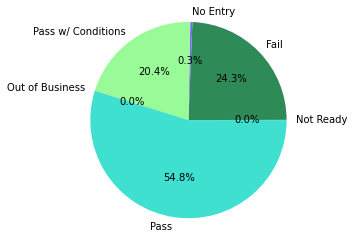

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = countResultsdf['results']
sizes = countResultsdf['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In [34]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
    
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = data.select(label(data.Results).alias('label'), data.Violations).where('label >= 0')

In [35]:
labeledData.take(1)

[Row(label=0.0, Violations='3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: SEE VIOLATION #60.  | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: MUST PROVIDE HAND WASHING SIGNAGE AT ALL WASHBOWL AND HAND WASHING SINKS.\t | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: OBSERVED EXCESSIVE AMOUNT OF BLACK AND BROWN, SLIMY, MOLD-LIKE SUBSTANCES THROUGHOUT INTERIOR OF ICE MACHINE, AND COMING IN CONTACT WITH ICE. MUST REMOVE SUBSTANCE, DETAIL CLEAN AND SANITIZE MACHINE. PRIORITY FOUNDATION VIOLATION 7-38-005. CITATION ISSUED.  | 35. APPROVED THAWING METHODS USED - Comments: OBSERVED IMPROPER THAWING METHOD IN USE. OBSERVED FISH AND CRAB SITTING IN STANDING WATER IN 3 COMPARTMENT SINK. (CRAB @ 38.8F AND FISH @ 41F)INSTRUCTED MUST USE ONE OF THE FOLLOWING APPROVED METHOD FOR THAWING: IN REFRIGERATION, IN A MICROWAVE AS PART OF A CONTINUOUS COOKING PROCESS, OR COMPLETELY SUBMERGED UNDER RUNNIN

In [36]:
train, test = labeledData.randomSplit([0.7, 0.3], seed=13)

In [37]:
tokenizer = Tokenizer(inputCol="Violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
model = pipeline.fit(train)

In [38]:
predictionsDf = model.transform(test)
predictionsDf.registerTempTable('Predictions')
predictionsDf.columns

['label',
 'Violations',
 'words',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [39]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND label = 0) OR
                                        (prediction = 1 AND label = 1)""").count()
numInspections = predictionsDf.count()
print("There were", numInspections, "inspections and there were", numSuccesses, "successful predictions")
print("This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate")

There were 47809 inspections and there were 44433 successful predictions
This is a 92.93856805204041% success rate


In [40]:
true_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND label = 0").toPandas()
false_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND label = 1").toPandas()
true_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND label = 0").toPandas()
false_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND label = 1").toPandas()

(-1.1046748587624493,
 1.1002226159072028,
 -1.1182454449301418,
 1.1201022744142017)

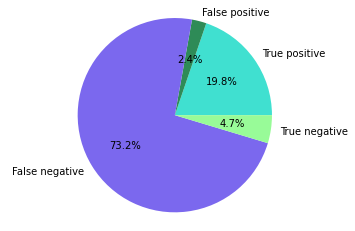

In [41]:
labels = ['True positive', 'False positive', 'False negative', 'True negative']
sizes = [true_positive['cnt'][0], false_positive['cnt'][0], false_negative['cnt'][0], true_negative['cnt'][0]]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')